The RandomizedLogisticRegression is not stable between kernels.
Just create a notebook and do all the analysis + print output to files,
So yoiu won't have problem on making the figures

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Read HDF file and phenotypes

In [3]:
final_SNPs = pd.read_hdf('data/BeanCAP_MDP_genotype_data.hdf5', 'snptable')
pheno_all = pd.read_csv('data/Adjusted-means-for-Agronomic-traits-with-race-and-market-calss-info.txt',
                       sep = '\t', header=0)
pheno_all.head()

,supop,market_class,taxa,df_co,dm_co,ch_co,lg_co,gh_co,sw_co,df_mi,...,dm_ne,ch_ne,lg_ne,sw_ne,df,dm,ch,lg,gh,sw
0,MA,black,115m,49,92,50,4,2,20.0,41,...,96,41,4,20.5,49,102,45,3.67,2.5,21.5
1,DJ,pink,6r_42,46,90,41,5,3,29.9,38,...,101,40,5,30.5,47,103,37,5.00,3.0,32.3
2,MA,black,92bg_7,49,87,48,3,3,22.8,44,...,79,33,2,21.7,50,92,39,2.33,2.5,21.7
3,DJ,pinto,92us_1006,46,82,45,1,2,30.3,38,...,78,45,1,29.2,45,90,43,1.33,2.0,31.3
4,MA,cream_caroca,a_285,51,94,55,3,3,22.2,45,...,95,40,3,20.9,52,103,48,3.00,2.5,23.1


Since it is the first analysis I will do some data exploration

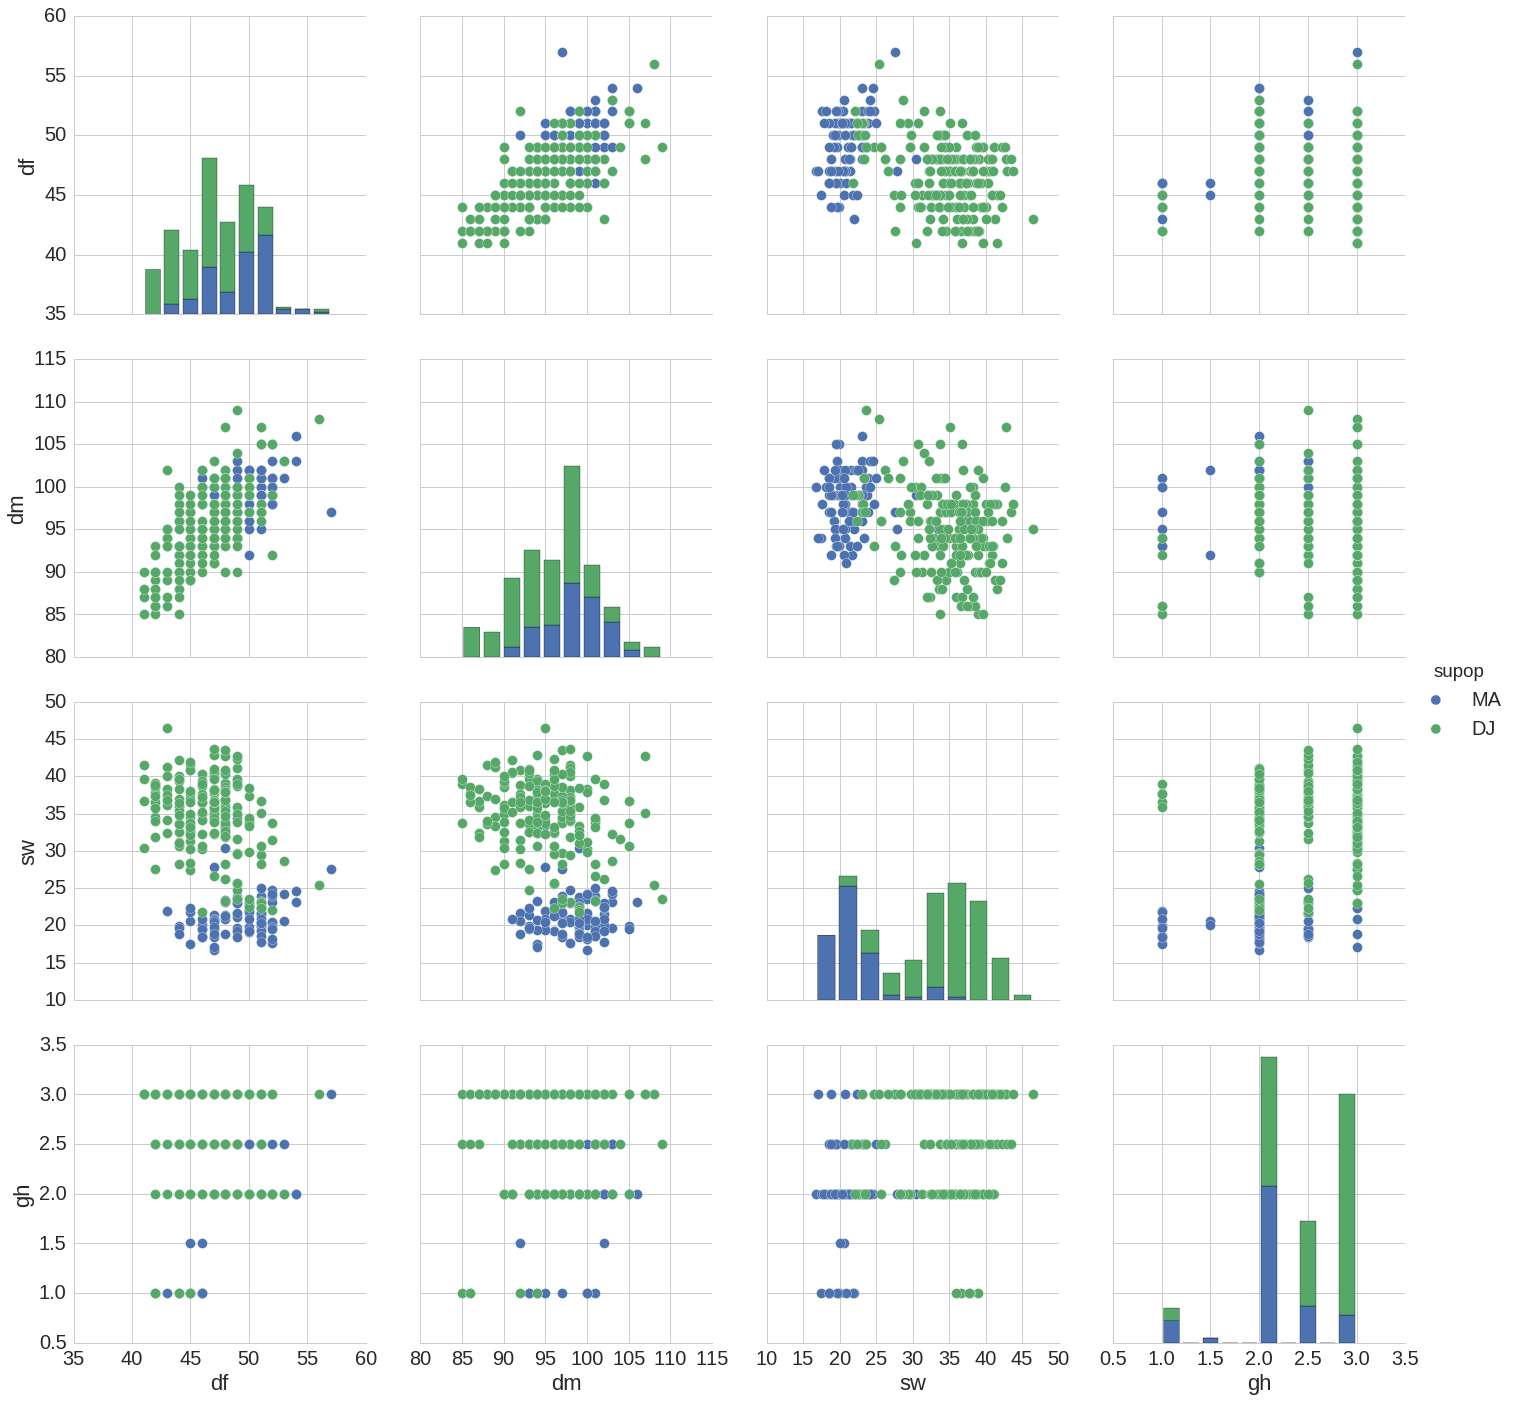

In [4]:
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.pairplot(pheno_all[['df', 'dm', 'sw', 'gh', 'supop']], hue='supop', size=5, 
             plot_kws={'s':100});

### 3 class plots

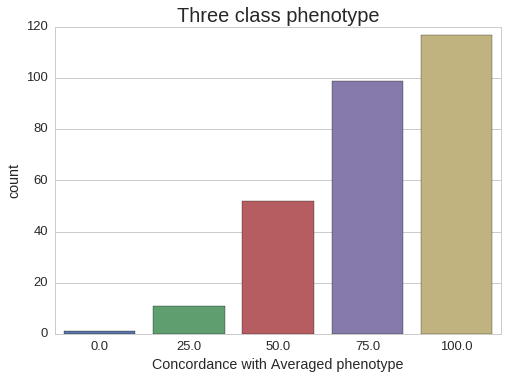

In [30]:
def multi_class(dataframe):
    l=[]
    for i in dataframe.columns:
        l.append(pd.qcut(dataframe[i], q=[0,.25, .75, 1], labels = False))
    return l

df_data = pheno_all[['df', 'df_co', 'df_mi','df_ne', 'df_nd']]
cl = multi_class(df_data)
cl_data = pd.DataFrame(cl).T
#sns.heatmap(cl_data)

avg = cl_data['df']
cl_data2 = cl_data.drop('df', axis=1)

l = []
for i in cl_data2.columns:
    l.append(cl_data2[i]==avg)
    
    
    
def get_perc(i):
    return (np.sum(i)/4)*100

sns.set(font_scale=1.3)
sns.set_style('whitegrid')
new = pd.DataFrame(l).T
x = new.apply(get_perc, axis=1)
sns.countplot(x)
plt.title('Three class phenotype', fontsize=20)
plt.xlabel('Concordance with Averaged phenotype');
    


### Early

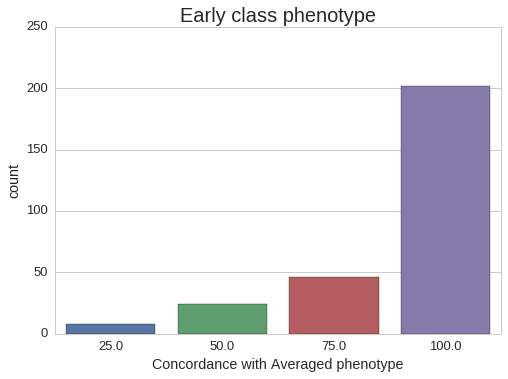

In [31]:
def multi_class(dataframe):
    l=[]
    for i in dataframe.columns:
        l.append(pd.qcut(dataframe[i], q=[0,.25, 1], labels = False))
    return l

df_data = pheno_all[['df', 'df_co', 'df_mi','df_ne', 'df_nd']]
cl = multi_class(df_data)
cl_data = pd.DataFrame(cl).T
#sns.heatmap(cl_data)

avg = cl_data['df']
cl_data2 = cl_data.drop('df', axis=1)

l = []
for i in cl_data2.columns:
    l.append(cl_data2[i]==avg)
    
    
    
def get_perc(i):
    return (np.sum(i)/4)*100

sns.set(font_scale=1.3)
sns.set_style('whitegrid')
new = pd.DataFrame(l).T
x = new.apply(get_perc, axis=1)
sns.countplot(x)
plt.title('Early class phenotype', fontsize=20)
plt.xlabel('Concordance with Averaged phenotype');
    

### Late

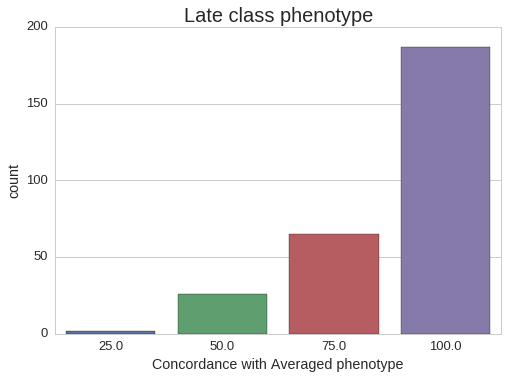

In [40]:
def multi_class(dataframe):
    l=[]
    for i in dataframe.columns:
        l.append(pd.qcut(dataframe[i], q=[0,.75, 1], labels = False))
    return l

df_data = pheno_all[['df', 'df_co', 'df_mi','df_ne', 'df_nd']]
cl = multi_class(df_data)
cl_data = pd.DataFrame(cl).T
#sns.heatmap(cl_data)

avg = cl_data['df']
cl_data2 = cl_data.drop('df', axis=1)

l = []
for i in cl_data2.columns:
    l.append(cl_data2[i]==avg)
    
    
    
def get_perc(i):
    return (np.sum(i)/4)*100

sns.set(font_scale=1.3)
sns.set_style('whitegrid')
new = pd.DataFrame(l).T
x = new.apply(get_perc, axis=1)
sns.countplot(x)
plt.title('Late class phenotype', fontsize=20)
plt.xlabel('Concordance with Averaged phenotype');
    

# All collection

Prepare phenotypes and genotypes for ML training

I will use the cross_val_score with **scorer='precision_micro'** for the classification. Then I will plot two graphs (1 DF and 1 DM) with mean +- std of the cv values (use 5 cv)

Create funcion with all the data in the model_prescreen script. N.B. for precision you should use a `make_scorer(precision_score, average=average)` like for precision_recall curve.
return a dataframe with all the prediction x classifier, so you can plot it with seaborn point_plot

I will analyze
1. Early (25 %)
2. Late (75 %)
3. 3 Classes

In [19]:
# import custom module
from model_prescreen import classification_task_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.feature_selection import SelectPercentile, SelectKBest, SelectFromModel, chi2, f_classif

## Feature selection approach

In [98]:
def feature_selector(X,y):
    selector = SelectPercentile(f_classif, percentile=5)
    selector.fit(X,y)
    return selector

#def feature_selector(X,y,model):
#    model.fit(X,y)
#    selector = SelectFromModel(model,threshold = 0.00001, prefit=True)
#    return selector

## Stratify byclass

## Early 25%

In [99]:
df = pheno_all['df']
df_classes = pd.qcut(df, q=[0,.25, 1], labels = False)

y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   stratify = y,
                                                   random_state = 101)



X_train_s = feature_selector(X_train, y_train).transform(X_train)

print(X_train_s.shape)
classification_prescreen_early = classification_task_score(X_train_s, y_train, 
                                                     strat=y_train, scorer='precision_macro',
                                                           cv = 5, jobs=7)

(224, 12181)
Processing KNeighbors model 1 of 9
Processing LogisticRegression model 2 of 9
Processing RandomForest model 3 of 9
Processing MLP model 4 of 9
Processing linearSVC model 5 of 9
Processing GradientBoosting model 6 of 9
Processing Bagging model 7 of 9
Processing SVC model 8 of 9
Processing SGD model 9 of 9


## Late 25

In [100]:
df = pheno_all['df']
df_classes = pd.qcut(df, q=[0,.75, 1], labels = False)

y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   stratify = y,
                                                   random_state = 101)


X_train_s = feature_selector(X_train, y_train).transform(X_train)
print(X_train_s.shape)
classification_prescreen_late = classification_task_score(X_train_s, y_train, 
                                                     strat=y_train, scorer='precision_macro',
                                                          cv = 5, jobs=7)

(224, 12181)
Processing KNeighbors model 1 of 9
Processing LogisticRegression model 2 of 9
Processing RandomForest model 3 of 9
Processing MLP model 4 of 9
Processing linearSVC model 5 of 9
Processing GradientBoosting model 6 of 9
Processing Bagging model 7 of 9
Processing SVC model 8 of 9
Processing SGD model 9 of 9


## 3 classes

In [101]:
df = pheno_all['df']
df_classes = pd.qcut(df, q=[0,.25, .75, 1], labels = False)

y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   stratify = y,
                                                   random_state = 101)


X_train_s = feature_selector(X_train, y_train).transform(X_train)
print(X_train_s.shape)

classification_prescreen_all = classification_task_score(X_train_s, y_train, 
                                                     strat=y_train, scorer='precision_macro',
                                                         cv = 5, jobs=7)

(224, 12181)
Processing KNeighbors model 1 of 9
Processing LogisticRegression model 2 of 9
Processing RandomForest model 3 of 9
Processing MLP model 4 of 9
Processing linearSVC model 5 of 9
Processing GradientBoosting model 6 of 9
Processing Bagging model 7 of 9
Processing SVC model 8 of 9
Processing SGD model 9 of 9


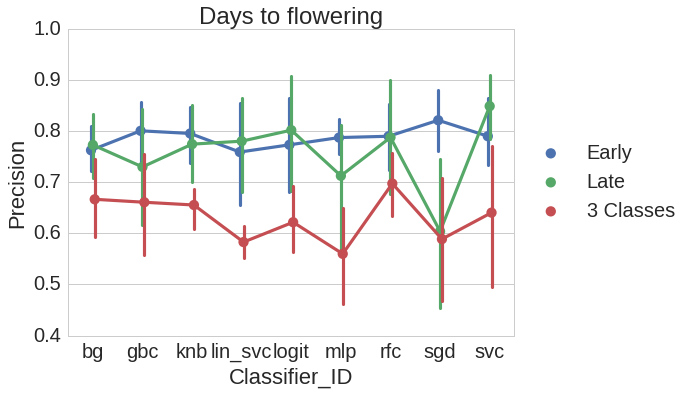

In [102]:
# plot both
sns.set(font_scale=2)
sns.set_style("whitegrid")
classification_prescreen_early['Class']=np.repeat('Early', classification_prescreen_early.shape[0])
classification_prescreen_late['Class']=np.repeat('Late', classification_prescreen_late.shape[0])
classification_prescreen_all['Class']=np.repeat('3 Classes', classification_prescreen_all.shape[0])
classification_df = pd.concat([classification_prescreen_early, 
                       classification_prescreen_late, classification_prescreen_all])


sns.pointplot(x='Classifier_ID', y='Score', hue='Class',
                   data = classification_df, dodge=True)
plt.ylabel('Precision')
plt.title('Days to flowering')
#plt.ylim((0,1))
plt.legend(loc='center right', bbox_to_anchor=(1.4, 0.5));

In [105]:
# save DF to file so you can plot again later
classification_df.to_csv('CV_DF_prediction_f1_classification.csv', sep=',', header=True, index=False)

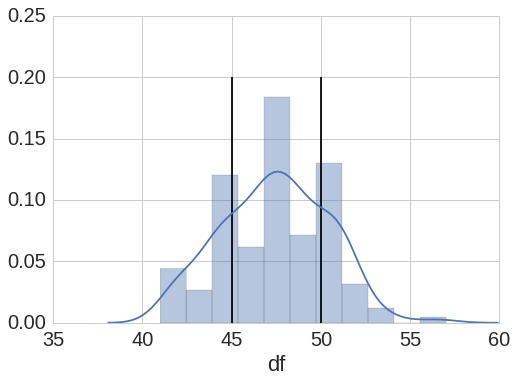

In [106]:
sns.distplot(df)
plt.vlines(np.percentile(df, 25), 0, .20)
plt.vlines(np.percentile(df, 75), 0, .20);

It seems that the best performance is achieved for 2 classes
I will try to improve the model with the 3 classes using different approaches:

1. RFC: best of the ensemble

2. SVC: Support vecrot

3. KNB:


# Prepare data-3 classes

Prepare data

In [107]:
from sklearn.metrics import precision_score, f1_score, classification_report, recall_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
df = pheno_all['df']
df_classes = pd.qcut(df, q=[0,.25, .75, 1], labels = False)

y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.8,
                                                   stratify = y,
                                                   random_state = 101)

# create function for evaluatin shit
def report_res(estimator, X_train, y_train, average):
    y_pred = cross_val_predict(estimator, X_train,
                                 y_train, groups=y_train,
                                 cv = 5, n_jobs=6)
    print(precision_score(y_train, y_pred, average=average))
    print(classification_report(y_train, y_pred))
    return(y_pred)


def feature_selector(X,y):
    selector = SelectPercentile(f_classif, percentile=5)
    selector.fit(X,y)
    return selector


selector = feature_selector(X_train, y_train)
X_train_s  = selector.transform(X_train)
print(X_train_s.shape)

(56, 12181)


## KNB

In [108]:
from sklearn.neighbors import KNeighborsClassifier

kn_default = KNeighborsClassifier()
y_pred = report_res(kn_default, X_train_s, y_train, 'macro')

0.750318309142
             precision    recall  f1-score   support

          0       0.65      0.69      0.67        16
          1       0.79      0.73      0.76        30
          2       0.82      0.90      0.86        10

avg / total       0.75      0.75      0.75        56



In [109]:
param_grid = {'n_neighbors':[5,10,20], 'weights':['uniform', 'distance'],
              'metric':['euclidean', 'manhattan', 'minkowski']
             }

kn = KNeighborsClassifier(n_jobs=-1)

kn_search_param = GridSearchCV(kn,param_grid=param_grid,
                                   scoring='precision_macro',n_jobs=6,iid=False,
                                   cv=5)
kn_search_param.fit(X_train_s, y_train)
print(kn_search_param.best_params_)
print(kn_search_param.best_estimator_)

y_pred=report_res(kn_search_param, X_train_s, y_train, 'macro')

{'n_neighbors': 10, 'metric': 'euclidean', 'weights': 'distance'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
           weights='distance')
0.735497835498
             precision    recall  f1-score   support

          0       0.70      0.88      0.78        16
          1       0.86      0.63      0.73        30
          2       0.64      0.90      0.75        10

avg / total       0.78      0.75      0.75        56



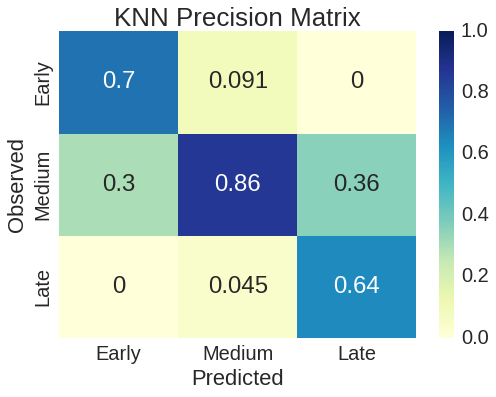

In [110]:
conf_matrix = confusion_matrix(y_train, y_pred)

# try different plots of the confusion matrix
norm_matrix = conf_matrix/conf_matrix.sum(axis=0, keepdims=True)
sns.heatmap(norm_matrix, annot=True, 
            xticklabels=['Early', 'Medium', 'Late'],
           yticklabels = ['Early', 'Medium', 'Late'], cmap="YlGnBu",
           vmin=0, vmax=1)
plt.ylabel('Observed')
plt.xlabel('Predicted')
plt.title('KNN Precision Matrix', fontsize=26)
plt.show()

In [111]:
X_test_s = selector.transform(X_test)
y_pred = kn_search_param.predict(X_test_s)
print(precision_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))

0.620378909383
             precision    recall  f1-score   support

          0       0.58      0.81      0.68        62
          1       0.76      0.50      0.60       122
          2       0.52      0.75      0.61        40

avg / total       0.67      0.63      0.63       224



## Linear_SVC

I can't improve the precision score (Always over 95%)

In [103]:
from sklearn.svm import LinearSVC

svc_default = LinearSVC(random_state=42)
y_pred = report_res(svc_default, X_train_s, y_train, 'macro')

0.639619883041
             precision    recall  f1-score   support

          0       0.62      0.64      0.63        39
          1       0.71      0.71      0.71        76
          2       0.58      0.56      0.57        25

avg / total       0.66      0.66      0.66       140



In [104]:
param_grid = {'penalty':['l2'],'loss':['hinge', 'squared_hinge'], 'C':np.logspace(-4,2,10),
              'class_weight': [None, 'balanced'],
              'dual':[True], 'tol': np.logspace(-5,-1, 5)
             }
lin_svc = LinearSVC(random_state=42)

svc_search_param = GridSearchCV(lin_svc, param_grid=param_grid,
                             scoring='precision_macro',n_jobs=6,iid=False,
                             cv = 5)

svc_search_param.fit(X_train_s, y_train)
print(svc_search_param.best_params_)
print(svc_search_param.best_estimator_)

y_pred=report_res(svc_search_param, X_train_s, y_train, 'macro')

{'C': 0.00046415888336127773, 'penalty': 'l2', 'class_weight': None, 'dual': True, 'tol': 1.0000000000000001e-05, 'loss': 'squared_hinge'}
LinearSVC(C=0.00046415888336127773, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=42,
     tol=1.0000000000000001e-05, verbose=0)
0.627246376812
             precision    recall  f1-score   support

          0       0.67      0.72      0.69        39
          1       0.69      0.68      0.69        76
          2       0.52      0.48      0.50        25

avg / total       0.66      0.66      0.66       140



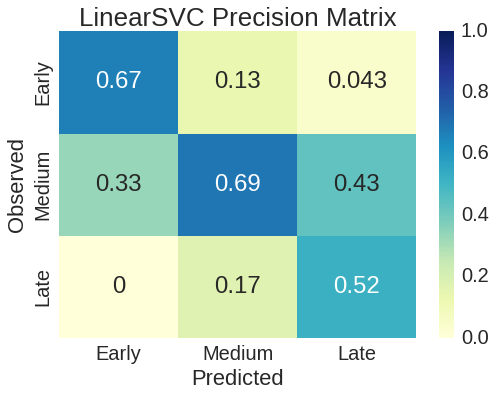

In [105]:
conf_matrix = confusion_matrix(y_train, y_pred)

# try different plots of the confusion matrix
norm_matrix = conf_matrix/conf_matrix.sum(axis=0, keepdims=True)
sns.heatmap(norm_matrix, annot=True, 
            xticklabels=['Early', 'Medium', 'Late'],
           yticklabels = ['Early', 'Medium', 'Late'], cmap="YlGnBu",
           vmin=0, vmax=1)
plt.ylabel('Observed')
plt.xlabel('Predicted')
plt.title('LinearSVC Precision Matrix', fontsize=26)
plt.show()

## Combine models

Should include also MLP

In [106]:
from sklearn.ensemble import VotingClassifier
# run again this

clf1 = lg_search_param.best_estimator_
clf2 = svc_search_param.best_estimator_

eclf = VotingClassifier(estimators=[('logit', clf1), ('linearSVC', clf2)], voting='hard')

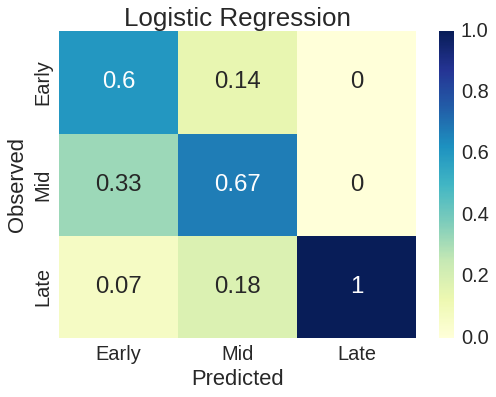

Precision Logistic Regression 0.75952140209
Precision Logistic Regression
             precision    recall  f1-score   support

          0       0.60      0.67      0.63        39
          1       0.67      0.82      0.74        76
          2       1.00      0.20      0.33        25

avg / total       0.71      0.66      0.64       140



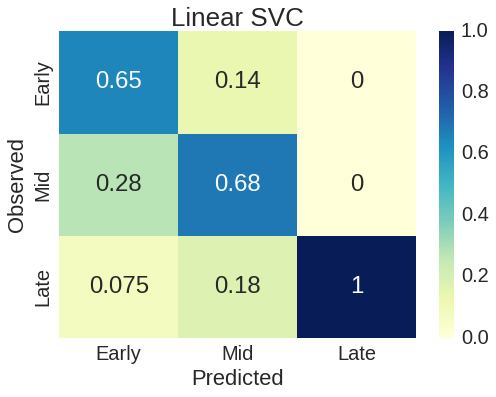

Precision Linear SVC 0.778070175439
Precision Linear SVC
             precision    recall  f1-score   support

          0       0.65      0.67      0.66        39
          1       0.68      0.86      0.76        76
          2       1.00      0.20      0.33        25

avg / total       0.73      0.69      0.66       140



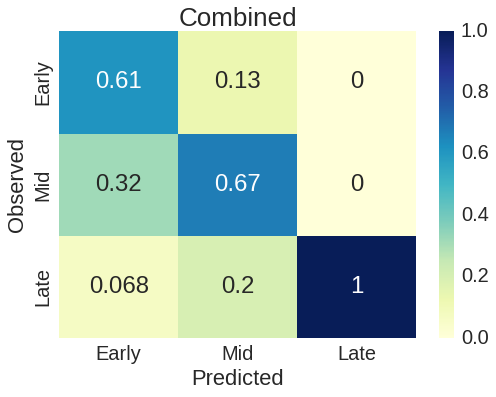

Precision Combined 0.762516469038
Precision Combined
             precision    recall  f1-score   support

          0       0.61      0.69      0.65        39
          1       0.67      0.82      0.74        76
          2       1.00      0.16      0.28        25

avg / total       0.72      0.66      0.63       140



In [107]:
X_test_s = selector.transform(X_test)
for clf, label in zip([clf1, clf2, eclf], ['Logistic Regression', 
                                           'Linear SVC', 'Combined']):
    clf.fit(X_train_s, y_train)
    pred = clf.predict(X_test_s)
    conf_matrix = confusion_matrix(y_test, pred)
# try different plots of the confusion matrix
    norm_matrix = conf_matrix/conf_matrix.sum(axis=0, keepdims=True)
    sns.heatmap(norm_matrix, annot=True, 
            xticklabels=['Early', 'Mid', 'Late'],
           yticklabels = ['Early', 'Mid', 'Late'], cmap="YlGnBu",
           vmin=0, vmax=1)
    plt.ylabel('Observed')
    plt.xlabel('Predicted')
    plt.title(label, fontsize=26)
    plt.show()
    print('Precision '+label, + precision_score(y_test, pred, average = 'macro'))
    print('Precision '+label + '\n'+ classification_report(y_test, pred))

# LG model

Precision Logistic Regression 0.600545686753
Precision Logistic Regression
             precision    recall  f1-score   support

          0       0.59      0.67      0.63        39
          1       0.66      0.75      0.70        76
          2       0.56      0.20      0.29        25

avg / total       0.62      0.63      0.61       140

Precision Linear SVC 0.623360037153
Precision Linear SVC
             precision    recall  f1-score   support

          0       0.64      0.72      0.67        39
          1       0.68      0.78      0.72        76
          2       0.56      0.20      0.29        25

avg / total       0.64      0.66      0.63       140

Precision Combined 0.611473672468
Precision Combined
             precision    recall  f1-score   support

          0       0.60      0.74      0.67        39
          1       0.67      0.74      0.70        76
          2       0.56      0.20      0.29        25

avg / total       0.63      0.64      0.62       140


In [ ]:
sELECT PERCENTILE k 20000 SEMBRA MOLTO BUONO COME APPROACH